In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


In [3]:
labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

In [4]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

<AxesSubplot: >

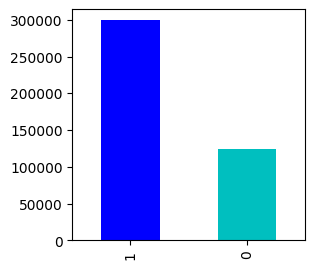

In [5]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

/tmp/ipykernel_18/3153187456.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  labels[['session_id_id', 'question_number']] = labels['session_id'].str.split('_', 1, expand=True)


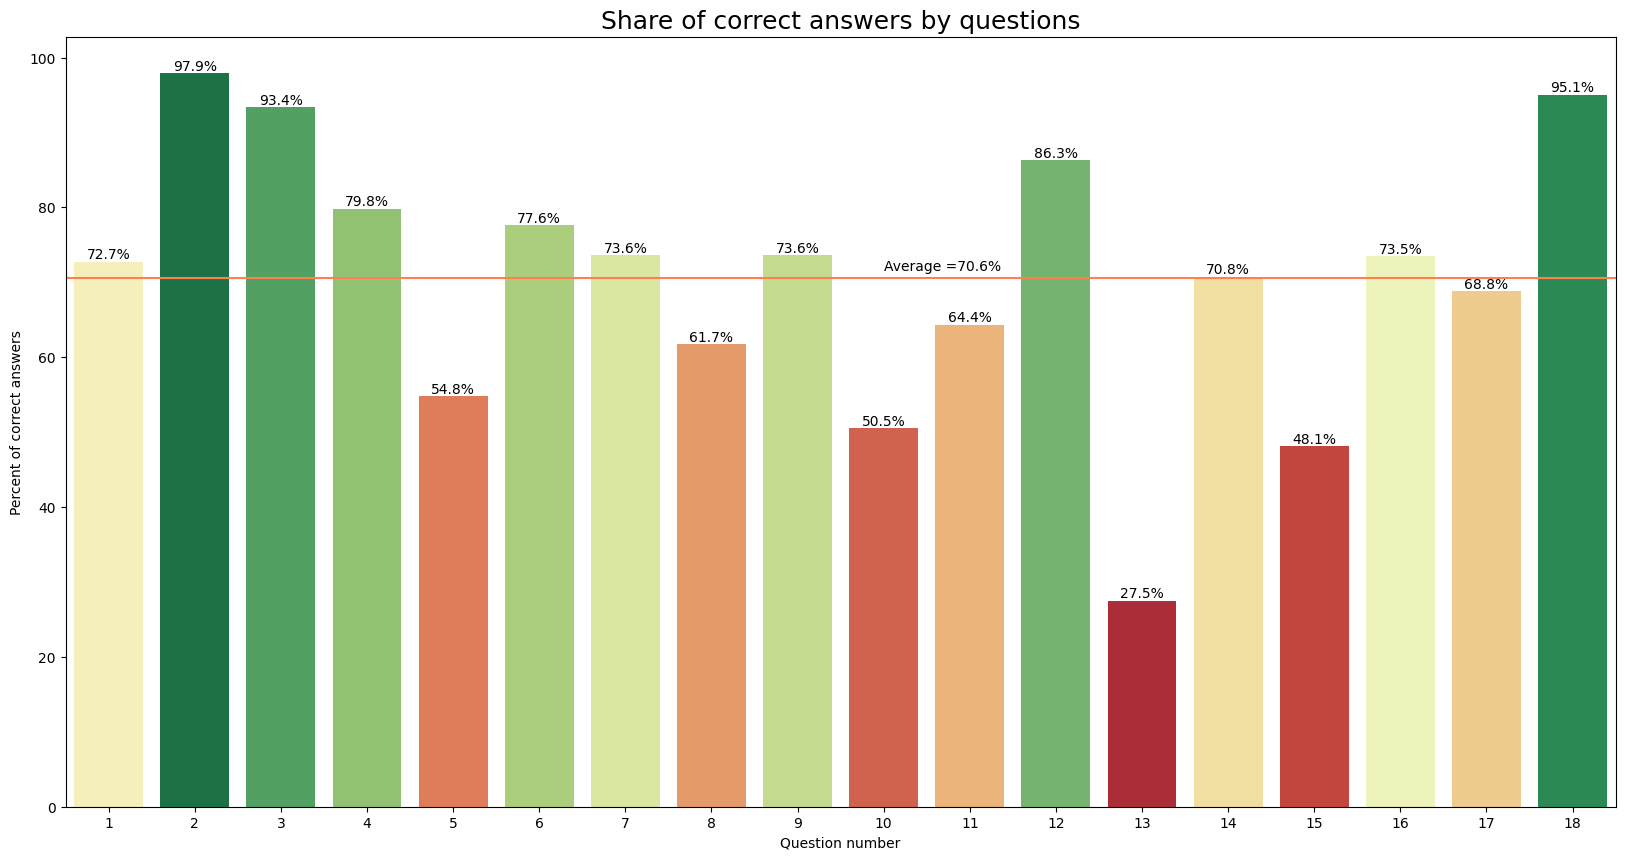

In [6]:
labels[['session_id_id', 'question_number']] = labels['session_id'].str.split('_', 1, expand=True)
labels['session_id_id'] = labels['session_id_id'].astype(np.int64)
mean_correct = (labels['correct'].mean()*100).astype(np.float64)

labels_perc = labels.groupby('question_number')['correct'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
labels_perc['number'] = labels_perc['question_number'].apply(lambda x: int(x[1:])).astype(np.int64)
labels_perc = labels_perc[labels_perc['correct'] == 1]
pal = sns.color_palette("RdYlGn", len(labels_perc))
rank = labels_perc.sort_values('number')['Percent'].argsort().argsort()
plt.figure(figsize=(20, 10))
g = sns.barplot(data=labels_perc, x='number', y="Percent", palette=np.array(pal[::])[rank])
g.axhline(mean_correct, color="coral")
plt.text(9, mean_correct+1, f'Average ={round(mean_correct, 1)}%')
g.axes.set_title("Share of correct answers by questions", fontsize=18)
g.set(xlabel='Question number', ylabel='Percent of correct answers')
g.bar_label(g.containers[0], fmt="%.1f%%")
del g, labels_perc, pal, rank, mean_correct

/tmp/ipykernel_18/725910899.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = sns.heatmap(dataset_df.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 15},fmt='.2f')


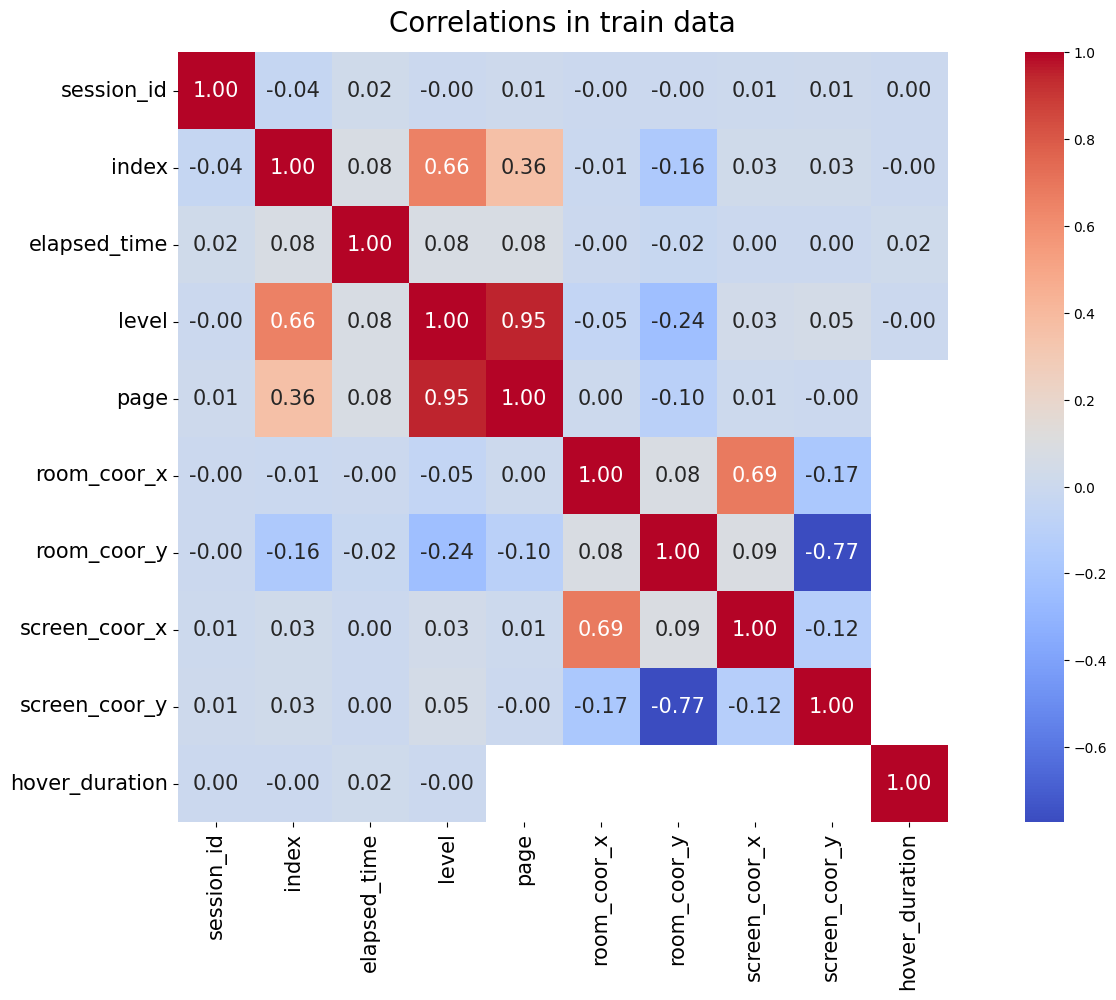

In [7]:
plt.figure(figsize=(20, 10))
g = sns.heatmap(dataset_df.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 15},fmt='.2f')
g.tick_params(axis='x', labelsize=15)
g.tick_params(axis='y', labelsize=15)
g.set_title('Correlations in train data', size=20, pad=15)
plt.show()

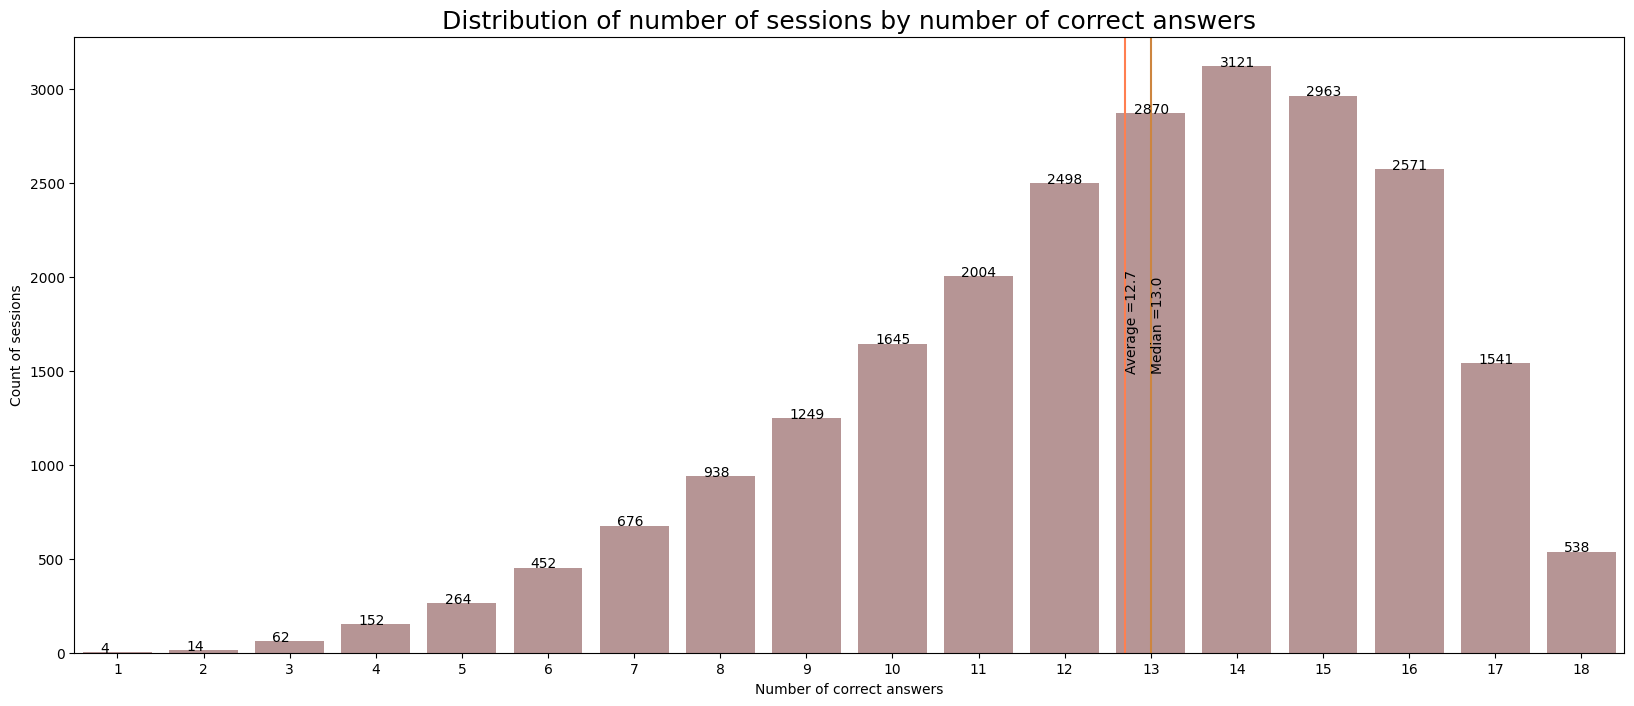

In [8]:
correct_answers_per_session = labels.groupby('session_id_id')['correct'].sum()
mean_correct_answers_per_session = correct_answers_per_session.mean()
median_correct_answers_per_session = correct_answers_per_session.median()
correct_answers_per_session = correct_answers_per_session.value_counts()
plt.figure(figsize=(20, 8))
g = sns.barplot(x=correct_answers_per_session.index, y=correct_answers_per_session.values, color='rosybrown')
plt.title('Distribution of number of sessions by number of correct answers', fontsize=18)
g.set_xticklabels(['{}'.format(int(num + 1)) for num in g.get_xticks()])
g.set(xlabel='Number of correct answers', ylabel='Count of sessions')
g.axvline(x=mean_correct_answers_per_session-1, color="coral")
g.text(mean_correct_answers_per_session-1, 1500, f'Average ={round(mean_correct_answers_per_session, 1)}', rotation=90)
g.axvline(x=median_correct_answers_per_session-1, color="peru")
g.text(median_correct_answers_per_session-1, 1500, f'Median ={round(median_correct_answers_per_session, 1)}', rotation=90)
for i, v in enumerate(correct_answers_per_session.sort_index().values):
    plt.text(i-0.2, v, str(int(v)))
del correct_answers_per_session, mean_correct_answers_per_session, median_correct_answers_per_session, i, v
plt.show()

In [9]:
def get_session_id_features(data):
    session_ids = pd.DataFrame()
    session_ids['session_id'] = data['session_id'].unique()
    session_ids['year'] = session_ids['session_id'].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    session_ids['month'] = session_ids['session_id'].apply(lambda x: int(str(x)[2:4]) + 1).astype(np.uint8)
    session_ids['weekday'] = session_ids['session_id'].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    session_ids['hour'] = session_ids['session_id'].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    session_ids['minute'] = session_ids['session_id'].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    session_ids['second'] = session_ids['session_id'].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    session_ids['ms'] = session_ids['session_id'].apply(lambda x: int(str(x)[12:15])).astype(np.uint16)
    session_ids['unknown_part'] = session_ids['session_id'].apply(lambda x: int(str(x)[15:17])).astype(np.uint8)
    return session_ids

train_session_ids = get_session_id_features(dataset_df)
train_session_ids.head()

,session_id,year,month,weekday,hour,minute,second,ms,unknown_part
0,20090312431273200,20,10,3,12,43,12,732,0
1,20090312433251036,20,10,3,12,43,32,510,36
2,20090312455206810,20,10,3,12,45,52,68,10
3,20090313091715820,20,10,3,13,9,17,158,20
4,20090313571836404,20,10,3,13,57,18,364,4


/tmp/ipykernel_18/1039199006.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['{}'.format(int(num)) for num in g.get_yticks()])


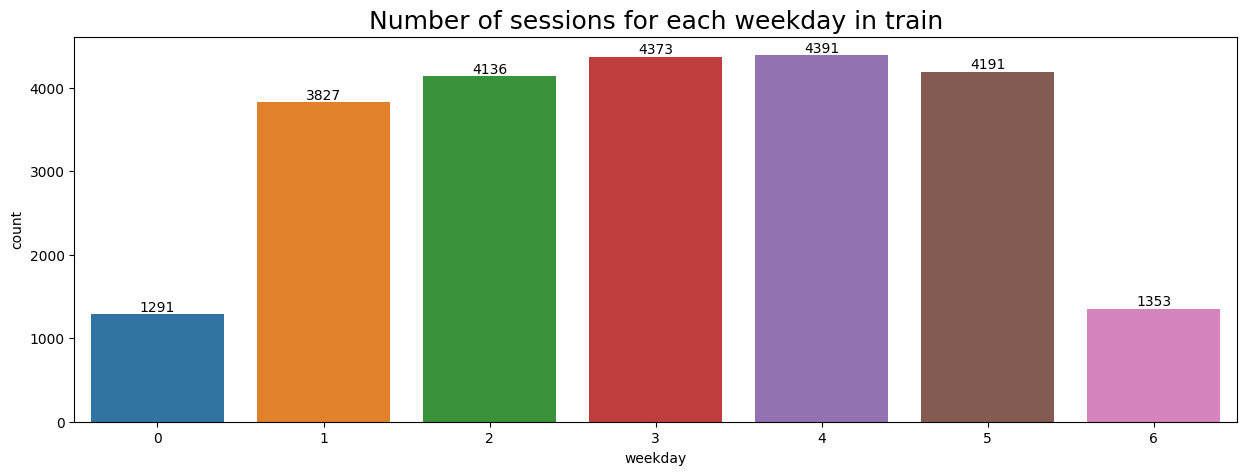

In [10]:
plt.figure(figsize=(15, 5))
g = sns.countplot(x='weekday', data=train_session_ids)
plt.title('Number of sessions for each weekday in train', fontsize=18)
g.set_yticklabels(['{}'.format(int(num)) for num in g.get_yticks()])
g.bar_label(g.containers[0])
g.xaxis.set_tick_params()
plt.show()

/tmp/ipykernel_18/1421791692.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['{}'.format(int(num)) for num in g.get_yticks()])


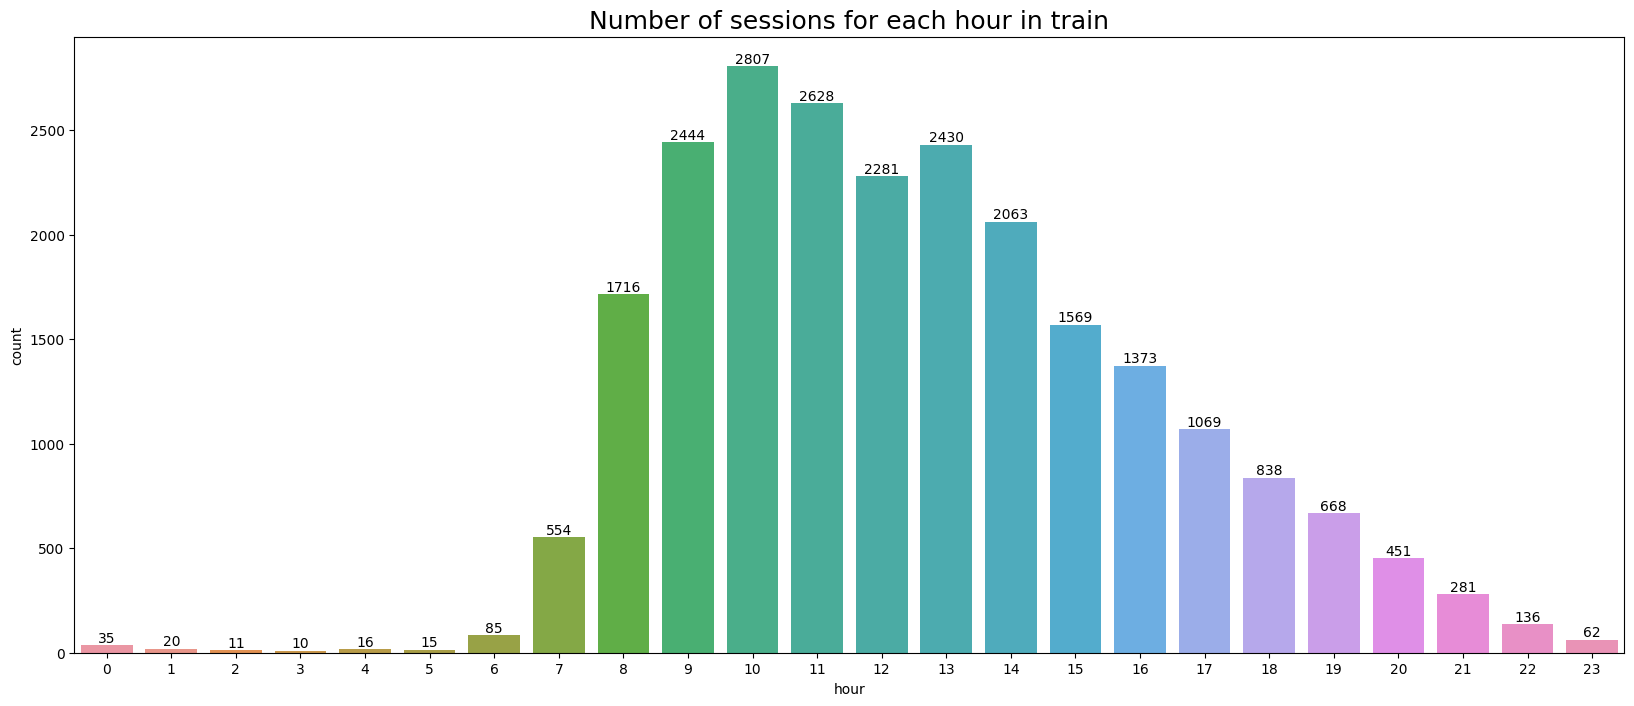

In [11]:
plt.figure(figsize=(20, 8))
g = sns.countplot(x='hour', data=train_session_ids)
plt.title('Number of sessions for each hour in train', fontsize=18)
g.set_yticklabels(['{}'.format(int(num)) for num in g.get_yticks()])
g.bar_label(g.containers[0])
g.xaxis.set_tick_params()
plt.show()
del train_session_ids, g

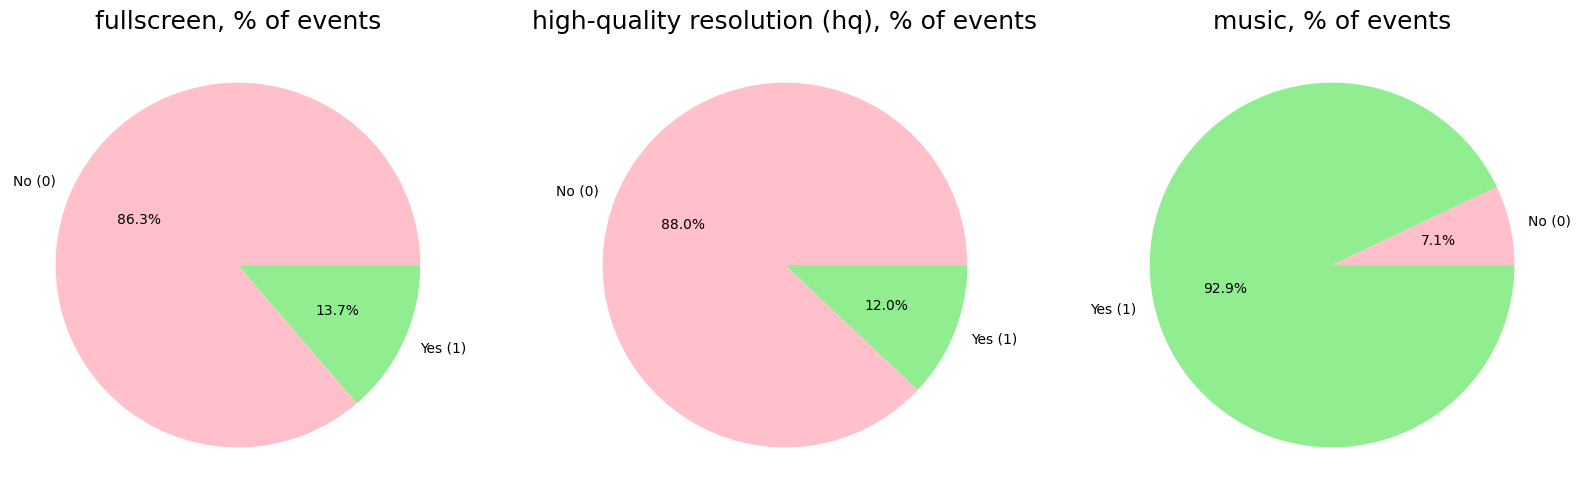

In [12]:
plt.figure(figsize=(20, 14))
plt.subplot(1, 3, 1)
plt.pie(dataset_df['fullscreen'].value_counts().sort_index(), labels = ['No (0)', 'Yes (1)'], colors = ['pink', 'lightgreen'], autopct='%.1f%%')
plt.title('fullscreen, % of events', fontsize=18)

plt.subplot(1, 3, 2)
plt.pie(dataset_df['hq'].value_counts().sort_index(), labels = ['No (0)', 'Yes (1)'], colors = ['pink', 'lightgreen'], autopct='%.1f%%')
plt.title('high-quality resolution (hq), % of events', fontsize=18)

plt.subplot(1, 3, 3)
plt.pie(dataset_df['music'].value_counts().sort_index(), labels = ['No (0)', 'Yes (1)'], colors = ['pink', 'lightgreen'], autopct='%.1f%%')
plt.title('music, % of events', fontsize=18)
plt.show()

In [13]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# Reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

dataset_df = feature_engineer(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (70686, 22)


In [14]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

56547 examples in training, 14139 examples in testing.


In [15]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

To get started, we'll work with a Gradient Boosted Trees Model. This is one of the well-known Decision Forest training algorithms.

A Gradient Boosted Decision Tree is a set of shallow decision trees trained sequentially. Each tree is trained to predict and then "correct" for the errors of the previously trained trees.

In [16]:
rf = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpj1ykvtfu as temporary training directory


In [17]:
# Fetch the unique list of user sessions in the validation dataset. We assigned 
# `session_id` as the index of our feature engineered dataset. Hence fetching 
# the unique values in the index column will give us a list of users in the 
# validation set.
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is: 
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s. 
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

Before training the data we have to understand how level_groups and questions are associated to each other.

In this game the first quiz checkpoint(i.e., questions 1 to 3) comes after finishing levels 0 to 4. So for training questions 1 to 3 we will use data from the level_group 0-4. Similarly, we will use data from the level_group 5-12 to train questions from 4 to 13 and data from the level_group 13-22 to train questions from 14 to 18.

We will train a model for each question and store the trained model in the models dict.

In [18]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
   
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Gradient Boosted Trees Model with default settings. 
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.GradientBoostedTreesModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])

    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]         

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten() 

### q_no 1 grp 0-4


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:42:12.844764555+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_r332zas/model/ with prefix 45b181946a264fce
[INFO 2023-05-21T07:42:12.865779653+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 16ms/step
### q_no 2 grp 0-4


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:42:20.236702353+00:00 kernel.cc:1214] Loading model from path /tmp/tmpryjdm8j_/model/ with prefix ce18a2d9a0a24610
[INFO 2023-05-21T07:42:20.239619724+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 14ms/step
### q_no 3 grp 0-4


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:42:26.588080169+00:00 kernel.cc:1214] Loading model from path /tmp/tmpghcfx917/model/ with prefix 417a1b4c945a4425
[INFO 2023-05-21T07:42:26.591361415+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built


5/5 [==============================] - 0s 15ms/step
### q_no 4 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:42:37.540788979+00:00 kernel.cc:1214] Loading model from path /tmp/tmpnv6akm61/model/ with prefix 01c279d11ffb4cc4
[INFO 2023-05-21T07:42:37.55483273+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[

5/5 [==============================] - 0s 15ms/step
### q_no 5 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:42:43.746609141+00:00 kernel.cc:1214] Loading model from path /tmp/tmp2ymp3xfb/model/ with prefix 673701e2283043a5
[INFO 2023-05-21T07:42:43.754307934+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
### q_no 6 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:42:55.848133129+00:00 kernel.cc:1214] Loading model from path /tmp/tmpf6gvfgr0/model/ with prefix 6a30784bc61e4f2b
[INFO 2023-05-21T07:42:55.857323968+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built


5/5 [==============================] - 0s 15ms/step
### q_no 7 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:43:05.514715884+00:00 kernel.cc:1214] Loading model from path /tmp/tmpk0o0sefc/model/ with prefix 240b628a009346b3
[INFO 2023-05-21T07:43:05.520912538+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
### q_no 8 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:43:10.738366334+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvefwbyrk/model/ with prefix 26d0fdd0c3874a50
[INFO 2023-05-21T07:43:10.741718564+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built


5/5 [==============================] - 0s 15ms/step
### q_no 9 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:43:16.885836718+00:00 kernel.cc:1214] Loading model from path /tmp/tmpwghicis6/model/ with prefix e5429ed094814a00
[INFO 2023-05-21T07:43:16.893466111+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
### q_no 10 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:43:29.25755544+00:00 kernel.cc:1214] Loading model from path /tmp/tmpuv8jgqpg/model/ with prefix e526817753674642
[INFO 2023-05-21T07:43:29.268026078+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[

5/5 [==============================] - 0s 15ms/step
### q_no 11 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:43:35.588926917+00:00 kernel.cc:1214] Loading model from path /tmp/tmpiczk0wl0/model/ with prefix 19452e93a8a84cc8
[INFO 2023-05-21T07:43:35.596601496+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 14ms/step
### q_no 12 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:43:40.509044667+00:00 kernel.cc:1214] Loading model from path /tmp/tmpxzdpssxf/model/ with prefix c78bf5a427704163
[INFO 2023-05-21T07:43:40.515261181+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built


5/5 [==============================] - 0s 15ms/step
### q_no 13 grp 5-12


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:43:47.841720038+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjo6hf1fa/model/ with prefix 70e91854edc041d9
[INFO 2023-05-21T07:43:47.851555654+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
### q_no 14 grp 13-22


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:43:58.247000236+00:00 kernel.cc:1214] Loading model from path /tmp/tmpu4cei570/model/ with prefix 47bf4220701b41df
[INFO 2023-05-21T07:43:58.255156825+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built


5/5 [==============================] - 0s 16ms/step
### q_no 15 grp 13-22


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:44:05.215631372+00:00 kernel.cc:1214] Loading model from path /tmp/tmp5fx0w0ky/model/ with prefix 3ba5586f52d54533
[INFO 2023-05-21T07:44:05.225255779+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
### q_no 16 grp 13-22


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:44:09.973679018+00:00 kernel.cc:1214] Loading model from path /tmp/tmpwangcpcm/model/ with prefix 905a456423be43a1
[INFO 2023-05-21T07:44:09.976807329+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built


5/5 [==============================] - 0s 14ms/step
### q_no 17 grp 13-22


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:44:15.727422431+00:00 kernel.cc:1214] Loading model from path /tmp/tmpa_75de3_/model/ with prefix a4bc08723e474894
[INFO 2023-05-21T07:44:15.733425946+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
### q_no 18 grp 13-22


/tmp/ipykernel_18/2226419128.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/2226419128.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 2023-05-21T07:44:33.05362713+00:00 kernel.cc:1214] Loading model from path /tmp/tmpiawp52mq/model/ with prefix ea84e0068f284a77
[INFO 2023-05-21T07:44:33.082761901+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[

5/5 [==============================] - 0s 15ms/step


In [19]:
for name, value in evaluation_dict.items():
    print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7286
question 2: accuracy 0.9743
question 3: accuracy 0.9351
question 4: accuracy 0.7957
question 5: accuracy 0.6319
question 6: accuracy 0.7885
question 7: accuracy 0.7456
question 8: accuracy 0.6355
question 9: accuracy 0.7632
question 10: accuracy 0.6109
question 11: accuracy 0.6522
question 12: accuracy 0.8695
question 13: accuracy 0.7218
question 14: accuracy 0.7337
question 15: accuracy 0.6166
question 16: accuracy 0.7486
question 17: accuracy 0.7027
question 18: accuracy 0.9510

Average accuracy 0.7558526065614488


In [20]:
tfdf.model_plotter.plot_model_in_colab(models['0-4_1'], tree_idx=0, max_depth=3)

In [21]:
inspector = models['0-4_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Available variable importances:
	 NUM_NODES
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE


In [22]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("room_fqid_nunique" (1; #16), 9.0),
 ("level" (1; #7), 5.0),
 ("name_nunique" (1; #9), 5.0),
 ("text_fqid_nunique" (1; #21), 5.0),
 ("hover_duration_std" (1; #6), 4.0),
 ("page" (1; #10), 4.0),
 ("screen_coor_x_std" (1; #18), 4.0),
 ("elapsed_time" (1; #1), 2.0),
 ("page_std" (1; #11), 2.0),
 ("room_coor_x" (1; #12), 2.0),
 ("event_name_nunique" (1; #3), 1.0),
 ("room_coor_y_std" (1; #15), 1.0)]